<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [2]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [3]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [4]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [5]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [6]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.19 seconds


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Crank-Nicolson method took 0.22 seconds


and finally, plot the results side-by-side

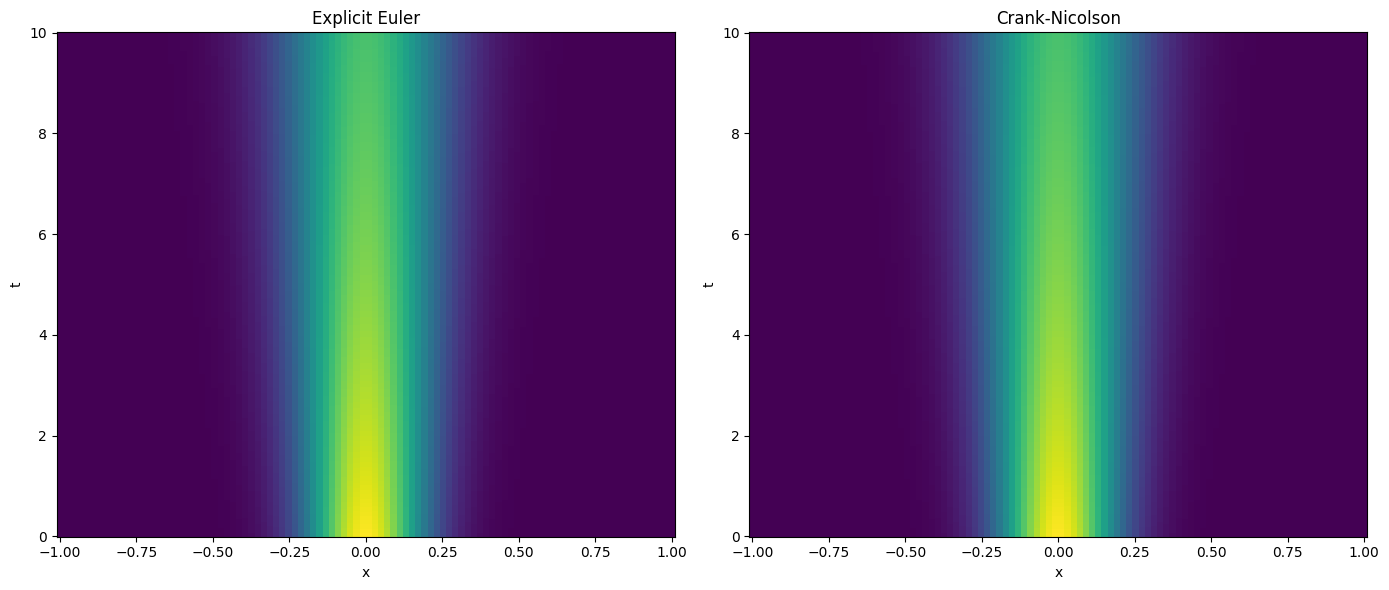

In [7]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing Nx (decreasing the grid spacing, $\Delta x$) and/or increase the diffusivity, $\kappa$, and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

The failure of explicit Euler is observed to happen when Nx>450 while kappa is keeping 0.001. The failure occurs because of the CFL (Courant-Friedrichs-Lewy) condition for the Explicit Euler method. The CFL condition ensures stability and is given by:
$$
\Delta t \leq \frac{\Delta x^2}{2\kappa}
$$
Therefore, for increasing Nx, grid space $\Delta x$ decreases, $\Delta x^2$ decreases exponentially. for unchanged $\kappa$, $\Delta t$ must decrease to maintain this stability but it doesn't. Large oscillation is observed for large Nx, and the time step is too large. $$$$For increasing $\kappa$ (keeping Nx the same), explicit euler's failure is also observed to happen when $\kappa$ exceeding 0.03. It is also evident for that CFL is governing its stability.
No failure is observed for Crank-Nicolson, as it is unconditionally stable for the diffusion equation (does not depend on $\Delta x$ or $\Delta t$). The Crank-Nicolson method solves a linear system at each time step, "A = sp.eye(Nx) - 0.5 * dt * kappa * M
A_inv = spla.inv(A)
c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
". It avoids the catastrophic error amplification seen in Explicit Euler, maintaining a valid solution even for very fine grids. However, the time comsuming is increasing for larger Nx for CN.



Explicit Euler method took 0.34 seconds
Crank-Nicolson method took 1.92 seconds


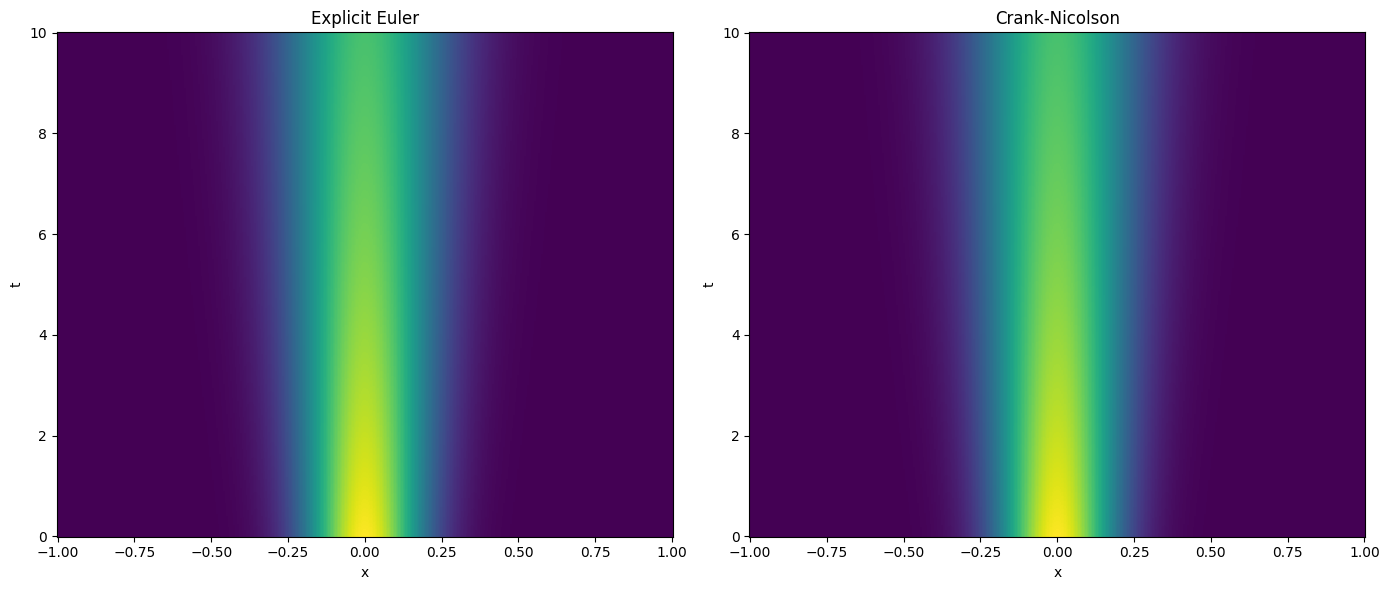

In [8]:
#testing parameter for stability
Nx = 440
kappa = 0.001
x = np.linspace(x_start, x_end, Nx)

c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()


Explicit Euler method took 0.22 seconds
Crank-Nicolson method took 1.15 seconds


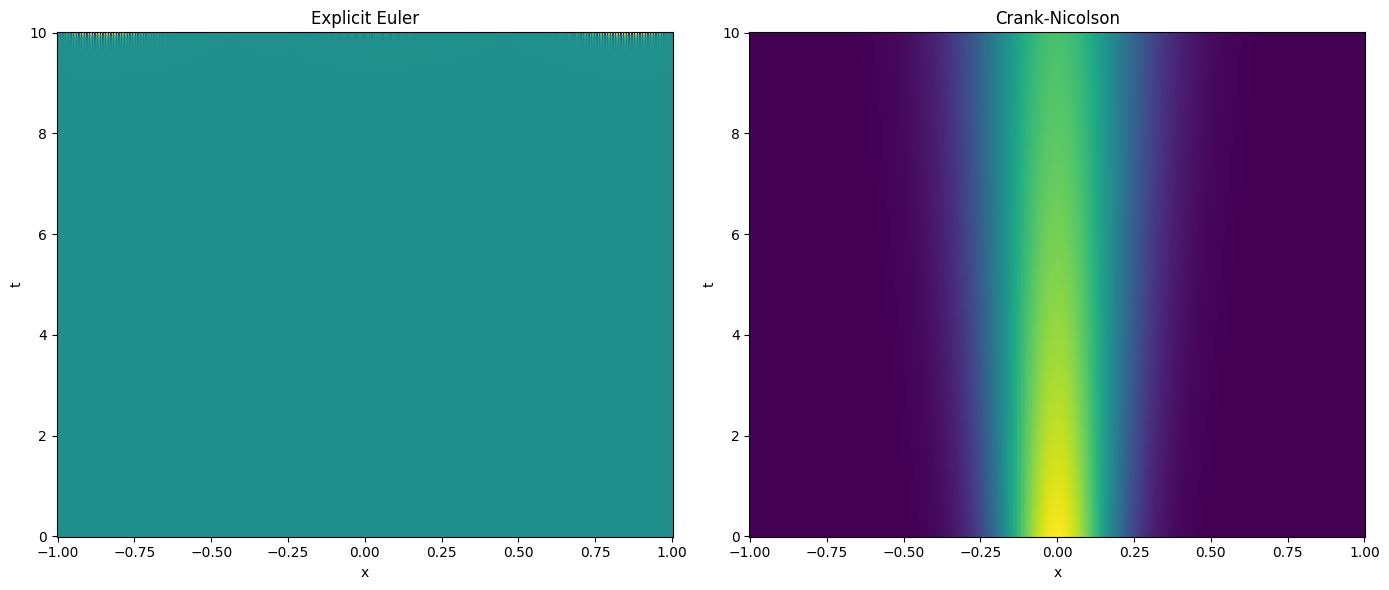

In [9]:
Nx = 460
kappa = 0.001
x = np.linspace(x_start, x_end, Nx)

c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()


<ipython-input-2-21a1127dc7c6>:25: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


Explicit Euler method took 0.36 seconds
Crank-Nicolson method took 2.46 seconds


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1370: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1371: RuntimeWarning: overflow encountered in scalar subtract
  resdat /= (vmax - vmin)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


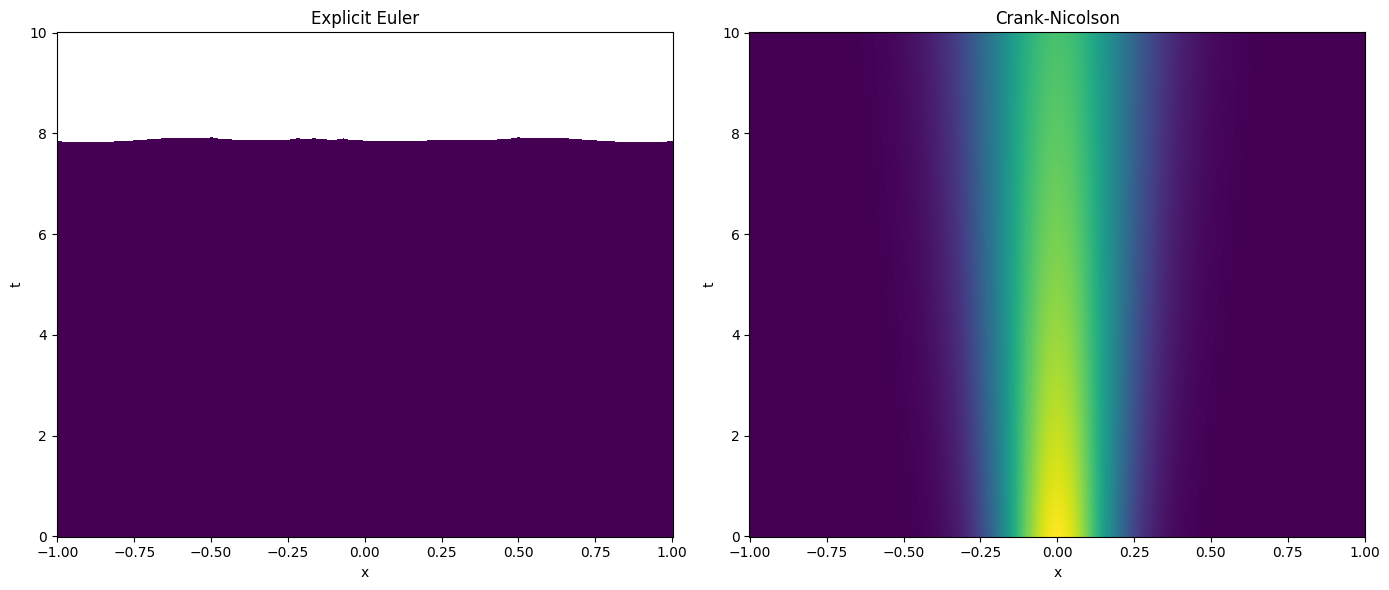

In [10]:

Nx = 600
kappa = 0.001
x = np.linspace(x_start, x_end, Nx)

c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()


Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.06 seconds


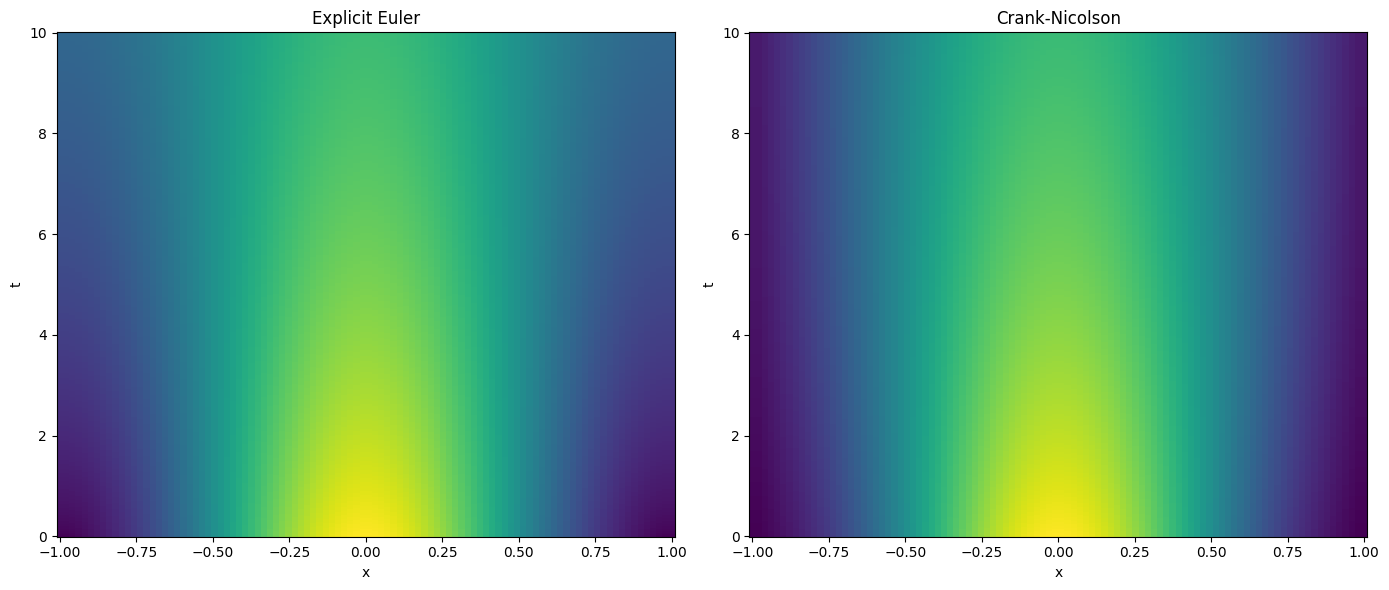

In [11]:

Nx = 100
kappa = 0.01
x = np.linspace(x_start, x_end, Nx)

c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()


Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.06 seconds


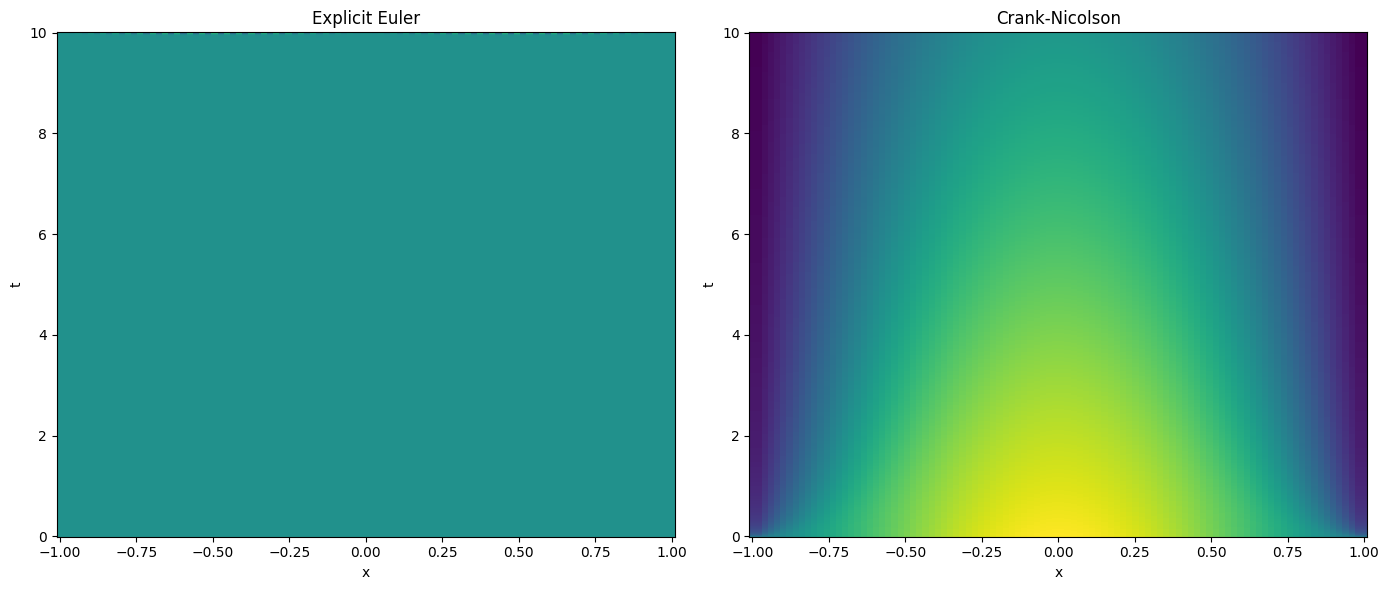

In [12]:

Nx = 100
kappa = 0.03
x = np.linspace(x_start, x_end, Nx)

c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()


<ipython-input-2-21a1127dc7c6>:25: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.06 seconds


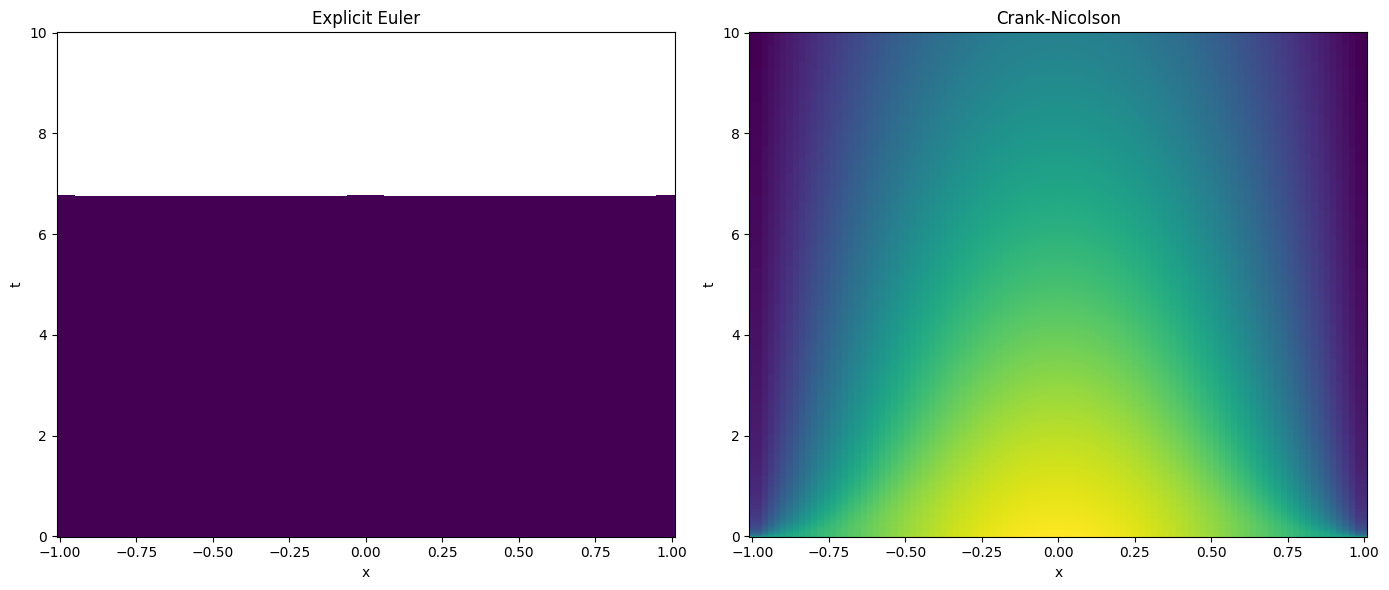

In [13]:

Nx = 100
kappa = 0.04
x = np.linspace(x_start, x_end, Nx)

c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()


### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds


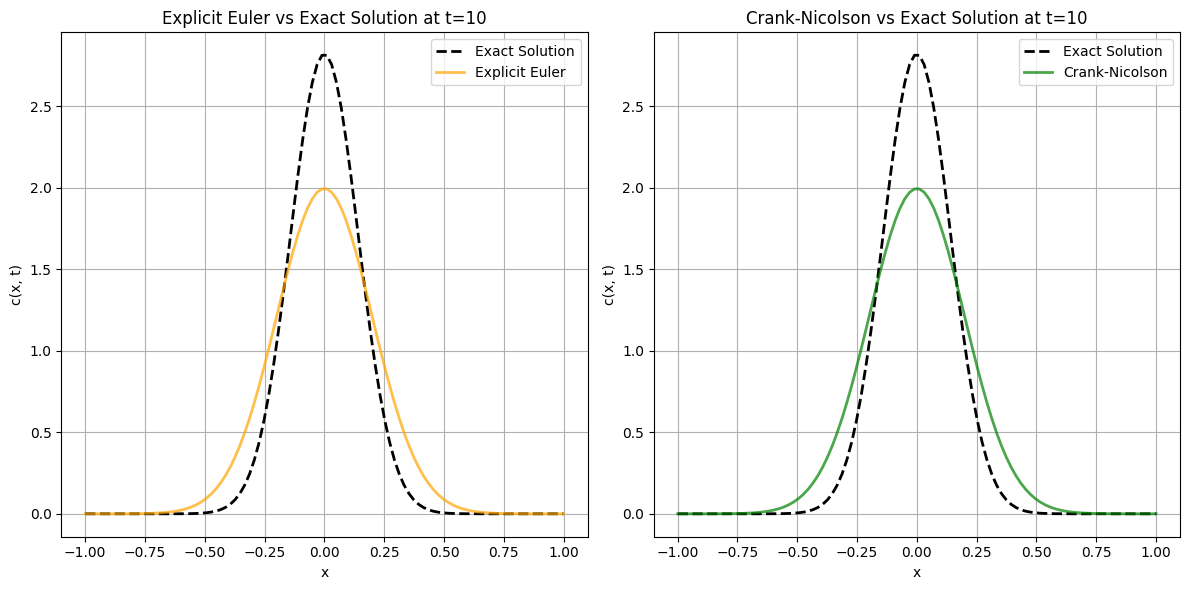

In [14]:
def exact_solution(x, kappa, t):
    return (1 / (4 * np.pi * kappa * t)**0.5) * np.exp(-x**2 / (4 * kappa * t))

kappa = 0.001
t_end = 10
Nx = 100

t = np.linspace(t_start, t_end, Nt)
x = np.linspace(x_start, x_end, Nx)

c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)

exact_c = exact_solution(x, kappa, t_end)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x, exact_c, label='Exact Solution', linestyle='dashed', color='black', linewidth=2)
plt.plot(x, c_EE[:, -1], label='Explicit Euler', alpha=0.7, color='orange', linestyle='-', linewidth=2)
plt.xlabel('x')
plt.ylabel('c(x, t)')
plt.title('Explicit Euler vs Exact Solution at t=10')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x, exact_c, label='Exact Solution', linestyle='dashed', color='black', linewidth=2)
plt.plot(x, c_CN[:, -1], label='Crank-Nicolson', alpha=0.7, color='green', linestyle='-', linewidth=2)
plt.xlabel('x')
plt.ylabel('c(x, t)')
plt.title('Crank-Nicolson vs Exact Solution at t=10')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

*DISCUSS* DEFINITION OF ERROR
here I would like to use the L2 norm (Euclidean norm) of the error, which is common in quantifying the difference between two functions. $$
E = \left( \sum_{i=1}^{N_x} \left( c_{\text{num}}(x_i) - c_{\text{exact}}(x_i) \right)^2 \right)^{1/2}
$$


Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.10 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.18 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.22 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.29 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.67 seconds
Explicit Euler method took 0.14 seconds
Crank-Nicolson method took 0.80 seconds


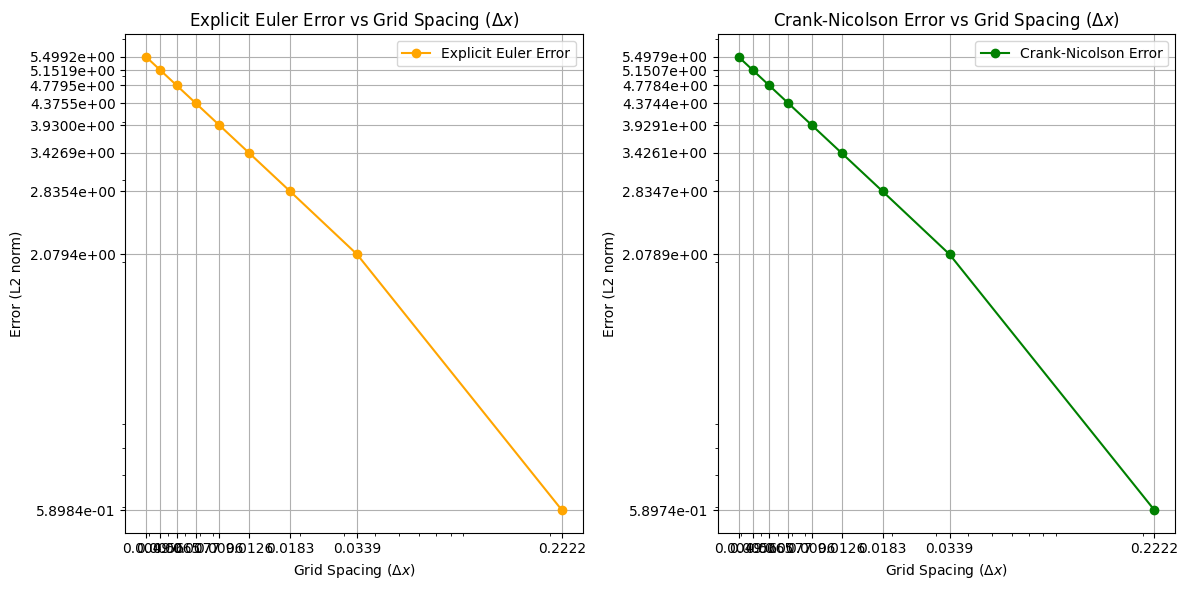

Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.05 seconds


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.08 seconds
Explicit Euler method took 0.13 seconds
Crank-Nicolson method took 0.12 seconds
Explicit Euler method took 0.23 seconds
Crank-Nicolson method took 0.16 seconds


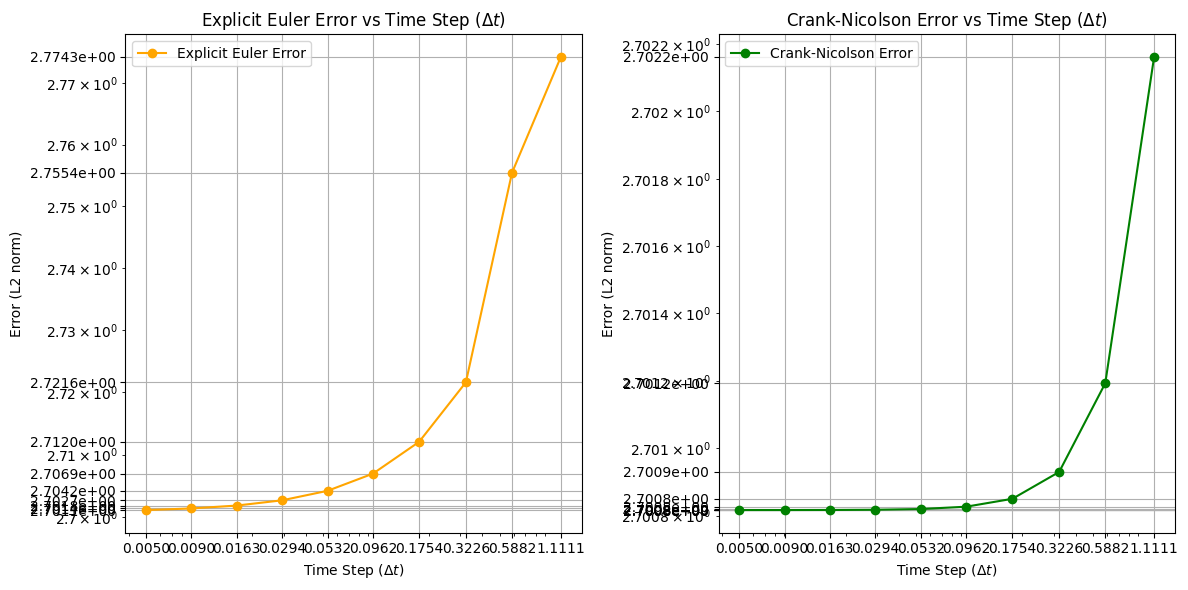

In [15]:
def compute_error(c_num, c_exact):
    return np.sqrt(np.sum((c_num - c_exact)**2))

kappa = 0.001
t_end = 10

Nx_values = np.arange(10, 451, 50)
errors_EE_x = []
errors_CN_x = []
dx_values = []


Nt_values = np.logspace(np.log10(10), np.log10(2000), num=10, dtype=int)
errors_EE_t = []
errors_CN_t = []
dt_values = []

for Nx in Nx_values:
    x = np.linspace(-1, 1, Nx)
    t = np.linspace(0, 10, 1000)
    dx = 2 / (Nx - 1)
    dx_values.append(dx)
    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)
    exact_c = exact_solution(x, kappa, t_end)
    error_EE = compute_error(c_EE[:, -1], exact_c)
    error_CN = compute_error(c_CN[:, -1], exact_c)
    errors_EE_x.append(error_EE)
    errors_CN_x.append(error_CN)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(dx_values, errors_EE_x, label='Explicit Euler Error', marker='o', linestyle='-', color='orange')
plt.xlabel('Grid Spacing ($\Delta x$)')
plt.ylabel('Error (L2 norm)')
plt.title('Explicit Euler Error vs Grid Spacing ($\Delta x$)')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xticks(dx_values, [f'{dx:.4f}' for dx in dx_values])
plt.yticks(errors_EE_x, [f'{err:.4e}' for err in errors_EE_x])
plt.subplot(1, 2, 2)
plt.plot(dx_values, errors_CN_x, label='Crank-Nicolson Error', marker='o', linestyle='-', color='green')
plt.xlabel('Grid Spacing ($\Delta x$)')
plt.ylabel('Error (L2 norm)')
plt.title('Crank-Nicolson Error vs Grid Spacing ($\Delta x$)')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xticks(dx_values, [f'{dx:.4f}' for dx in dx_values])
plt.yticks(errors_CN_x, [f'{err:.4e}' for err in errors_CN_x])
plt.tight_layout()
plt.show()

for Nt in Nt_values:
    dt = 10 / (Nt - 1)
    dt_values.append(dt)
    x = np.linspace(-1, 1, 100)
    t = np.linspace(0, 10, Nt)
    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)
    exact_c = exact_solution(x, kappa, t_end)
    error_EE = compute_error(c_EE[:, -1], exact_c)
    error_CN = compute_error(c_CN[:, -1], exact_c)
    errors_EE_t.append(error_EE)
    errors_CN_t.append(error_CN)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(dt_values, errors_EE_t, label='Explicit Euler Error', marker='o', linestyle='-', color='orange')
plt.xlabel('Time Step ($\Delta t$)')
plt.ylabel('Error (L2 norm)')
plt.title('Explicit Euler Error vs Time Step ($\Delta t$)')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xticks(dt_values, [f'{dt:.4f}' for dt in dt_values])
plt.yticks(errors_EE_t, [f'{error:.4e}' for error in errors_EE_t])
plt.subplot(1, 2, 2)
plt.plot(dt_values, errors_CN_t, label='Crank-Nicolson Error', marker='o', linestyle='-', color='green')
plt.xlabel('Time Step ($\Delta t$)')
plt.ylabel('Error (L2 norm)')
plt.title('Crank-Nicolson Error vs Time Step ($\Delta t$)')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xticks(dt_values, [f'{dt:.4f}' for dt in dt_values])
plt.yticks(errors_CN_t, [f'{error:.4e}' for error in errors_CN_t])
plt.tight_layout()
plt.show()


Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

I created two lists of Nx and Nt values that work without failure for both Explicit Euler and Crank-Nicolson methods. Both methods were then run for each pair of Nx and Nt, and the time and error results were displayed in a scatter plot.

It is evident from the plot that Explicit Euler has significantly larger errors compared to Crank-Nicolson. I defined the tolerance based on this plot as the lower 75% of the total error distribution, which is 5.4641. The average computation time was calculated for each method using only the results that fell within this tolerance, yielding the following results:

EE average time: 6.0127e-02 seconds
CN average time: 1.4383e-01 seconds
From this, we can conclude that EE is more efficient than CN in terms of time when the error is within the specified tolerance. However, EE tends to generate larger errors if the grid sizes (Nx and Nt) are not constrained. Thus, while EE is faster, it is less reliable in terms of accuracy compared to CN. Therefore, EE should only be used when the grid resolution is carefully controlled to avoid large errors.

Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.00 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.11 seconds


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.15 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.16 seconds
Crank-Nicolson method took 0.10 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.05 seconds


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Crank-Nicolson method took 1.22 seconds
5.464163089971002


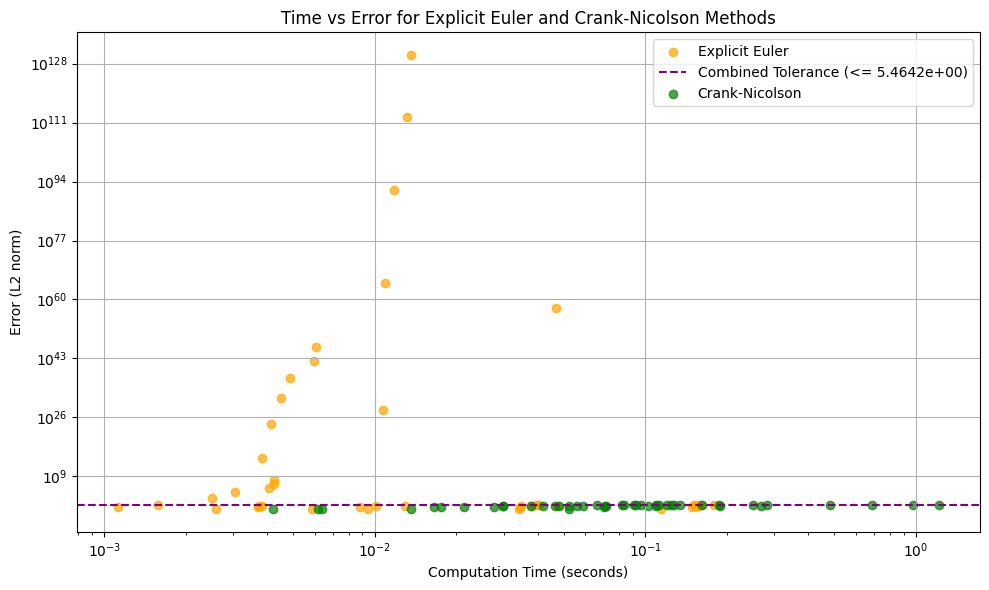

In [16]:
kappa = 0.001
t_end = 10

Nx_values = np.arange(5, 451, 50)
Nt_values = np.logspace(np.log10(10), np.log10(2000), num=5, dtype=int)

times_EE = []
times_CN = []
errors_EE = []
errors_CN = []

for Nx in Nx_values:
    for Nt in Nt_values:
        x = np.linspace(-1, 1, Nx)
        t = np.linspace(0, 10, Nt)
        dx = 2 / (Nx - 1)
        dt = 10 / (Nt - 1)

        start_time_EE = time.time()
        c_EE = EE(x, t, kappa)
        end_time_EE = time.time()
        time_EE = end_time_EE - start_time_EE

        start_time_CN = time.time()
        c_CN = CN(x, t, kappa)
        end_time_CN = time.time()
        time_CN = end_time_CN - start_time_CN

        exact_c = exact_solution(x, kappa, t_end)
        error_EE = compute_error(c_EE[:, -1], exact_c)
        error_CN = compute_error(c_CN[:, -1], exact_c)

        times_EE.append(time_EE)
        times_CN.append(time_CN)
        errors_EE.append(error_EE)
        errors_CN.append(error_CN)

combined_errors = errors_EE + errors_CN
combined_tolerance = np.percentile(combined_errors, 75)
print(combined_tolerance)
plt.figure(figsize=(10, 6))
plt.scatter(times_EE, errors_EE, label='Explicit Euler', marker='o', color='orange', alpha=0.7)
plt.axhline(y=combined_tolerance, color='purple', linestyle='--', label=f'Combined Tolerance (<= {combined_tolerance:.4e})')
plt.scatter(times_CN, errors_CN, label='Crank-Nicolson', marker='o', color='green', alpha=0.7)
plt.xlabel('Computation Time (seconds)')
plt.ylabel('Error (L2 norm)')
plt.title('Time vs Error for Explicit Euler and Crank-Nicolson Methods')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()


Updated Nx values: [5, 55, 105, 155, 205, 255, 305, 355]
Updated Nt values: [10, 37, 141, 531, 2000]
Average time for Explicit Euler (EE): 6.1052e-02 seconds
Average time for Crank-Nicolson (CN): 1.4534e-01 seconds


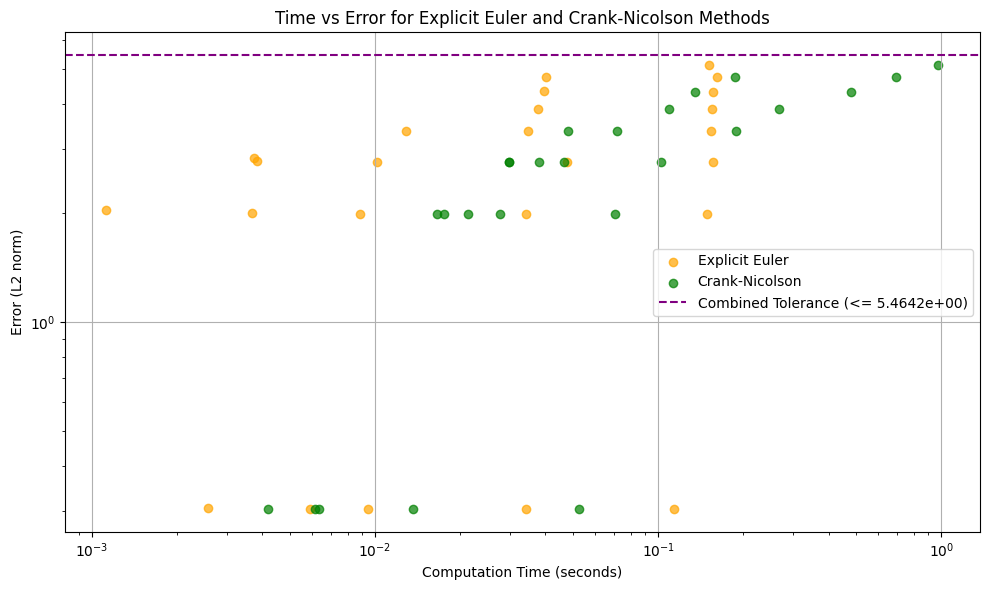

In [17]:
filtered_Nx_values = []
filtered_Nt_values = []
filtered_times_EE = []
filtered_times_CN = []
filtered_errors_EE = []
filtered_errors_CN = []

for i in range(len(errors_EE)):
    if errors_EE[i] <= combined_tolerance:
        filtered_Nx_values.append(Nx_values[i // len(Nt_values)])
        filtered_Nt_values.append(Nt_values[i % len(Nt_values)])
        filtered_times_EE.append(times_EE[i])
        filtered_times_CN.append(times_CN[i])
        filtered_errors_EE.append(errors_EE[i])
        filtered_errors_CN.append(errors_CN[i])

filtered_Nx_values = list(sorted(set(filtered_Nx_values), key=filtered_Nx_values.index))
filtered_Nt_values = list(sorted(set(filtered_Nt_values), key=filtered_Nt_values.index))

print("Updated Nx values:", filtered_Nx_values)
print("Updated Nt values:", filtered_Nt_values)

avg_time_EE = np.mean(filtered_times_EE)
avg_time_CN = np.mean(filtered_times_CN)

print(f"Average time for Explicit Euler (EE): {avg_time_EE:.4e} seconds")
print(f"Average time for Crank-Nicolson (CN): {avg_time_CN:.4e} seconds")

plt.figure(figsize=(10, 6))
plt.scatter(filtered_times_EE, filtered_errors_EE, label='Explicit Euler', marker='o', color='orange', alpha=0.7)
plt.scatter(filtered_times_CN, filtered_errors_CN, label='Crank-Nicolson', marker='o', color='green', alpha=0.7)
plt.axhline(y=combined_tolerance, color='purple', linestyle='--', label=f'Combined Tolerance (<= {combined_tolerance:.4e})')
plt.xlabel('Computation Time (seconds)')
plt.ylabel('Error (L2 norm)')
plt.title('Time vs Error for Explicit Euler and Crank-Nicolson Methods')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()


### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?